In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [15]:
# Network Parameters
num_input = 39
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [23]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 0:39])
#     print(data_x.shape)
    
    data_y = np.array(dataset.iloc[:, 40:41])
#     print(data_y.shape)

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    for i in range(len(all_foot)):
        strike_times.append([float(all_time[i]), all_foot[i]])
#     print(len(strike_times))

    # left - 0, right = 1
    strike_times.append([length/25.0, 'E'])
    step_direct = 0
    window_y = []
    strike_index=0
    for i in range(length):
        if(strike_index<len(strike_times) and i/25.0 < strike_times[strike_index][0]):
            window_y.append(step_direct)
        else:
            step_direct = 1-step_direct
            strike_index += 1
            window_y.append(step_direct)
            
    return window_y

In [24]:
data_x = []
window_y = []
for i in range(1,6):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_GD.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i:i+timesteps]
        data_x.append(x)
        window_y.append(y)
        
for i in range(1,6):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_WC.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i:i+timesteps]
        data_x.append(x)
        window_y.append(y)    

        
print(len(data_x)) #21843
print(len(window_y))

order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

41306
41306
41306


In [46]:
test_x, test_y=[], []
for i in range(6,7):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_GD.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i:i+timesteps]
        test_x.append(x)
        test_y.append(y)
        
# for i in range(6,7):
#     data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_WC.csv')
#     window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
#     for i in range(len(data_x_part)-timesteps):
#         x=data_x_part[i:i+timesteps]
#         y=window_y_part[i+timesteps]
#         test_x.append(x)
#         test_y.append(y)
        
print(len(test_x))

2393


In [43]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps])

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }

#     init_op = tf.global_variables_initializer()
#     saver = tf.train.Saver()    
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
#         outputs = tf.transpose(outputs, [1,0,2])
#         return tf.matmul(outputs[-1], weights['out']) + biases['out']

        print(outputs.shape)
        outputs = tf.reshape(outputs, [-1, num_hidden])
        print(outputs.shape)
        predictions = tf.contrib.layers.fully_connected(outputs, 1, None)
        return predictions
    

    logits = RNN(X, weights, biases)
    print(logits.shape)
    logits = tf.reshape(logits, [-1])
    print(logits.shape)
    print(Y.shape)
    labels = tf.reshape(Y, [-1])
    print(labels.shape)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, labels))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.0005).minimize(loss)
    
    saver = tf.train.Saver()

(?, 80, 100)
(?, 100)
(?, 1)
(?,)
(?, 80)
(?,)


In [48]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
train_x.extend(train_x[0:batch_size])
train_y.extend(train_y[0:batch_size])
training_steps = 1001

In [49]:
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 400 == 0):
            print('Loss at step %d: %f' % (step, l))
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-timestamp-xxx.ckpt', global_step=step)
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-timestamp-xxx.ckpt-10000
Initialized
Loss at step 0: 0.058285
Loss at step 400: 0.064507
Loss at step 800: 0.055883


In [62]:
test_y[0][0]

0

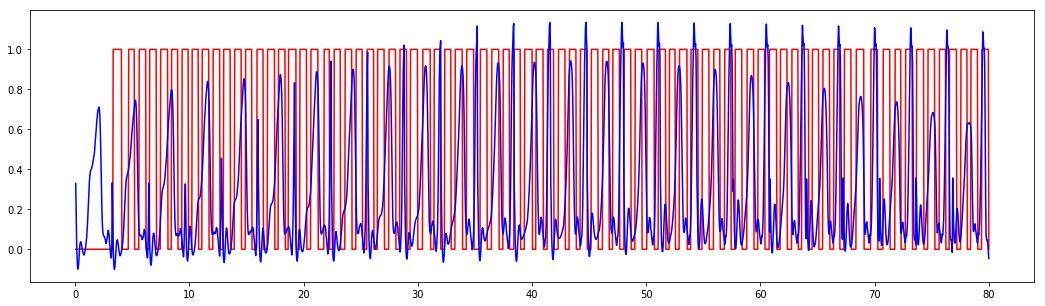

In [66]:
#0.150226
start=0
end=2000
plt.figure(figsize=(18, 5))
plt.plot([i[0][0] for i in test_x[start:end]], [i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0][0] for i in test_x[start:end]], [i for i in test_logits[start:end]], 'b')
plt.show()

In [67]:
# normal_test_logits_seq = [round(i[0]) for i in test_logits_seq]
#0.06
print(test_loss)

0.507997


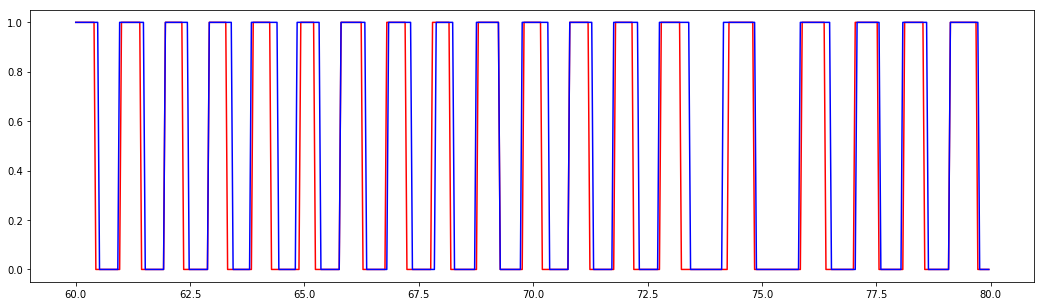

In [85]:
# print (len(normal_test_logits_seq))
# print (sum(normal_test_logits_seq))
# print (test_logits[-500:-400])
# print (normal_test_logits[-500:-400])

start=1500
end=2000
plt.figure(figsize=(18, 5))
plt.plot([i[0][0] for i in test_x[start:end]], [i[0] for i in test_y][start:end], 'r')
plt.plot([i[0][0] for i in test_x[start:end]], [round(i[0]) for i in test_logits][start:end], 'b')
plt.show()

In [69]:
count = 0
for i in range(0, len(test_x)):
    if(test_y[i] == round(test_logits[i])):
        count += 1;
print(count/len(test_x))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()